This script generates the allele frequency spectra in the main text and in the supplementary. It also generates statistics for the proportion of mutations that are driver etc etc.

In [1]:
%pylab inline
import pandas as pd
import seaborn as sns
from glob import glob
sns.set_style("white")
sns.despine()
# sns.set_context('talk')
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)



Populating the interactive namespace from numpy and matplotlib


In [5]:
# RED =  sns.xkcd_rgb["pale red"]
# GREEN = sns.xkcd_rgb["medium green"]
# BLUE = sns.xkcd_rgb["denim blue"]

def widths(arr):
    index = 0
    while index < len(arr)-1:
        yield arr[index+1] - arr[index]
        index += 1

def neighbour_iterator(arr):
    index = 0
    while index < len(arr)-1:
        yield (arr[index], arr[index+1])
        index += 1

numbins = 100

# binrange = np.linspace(0.00006, 0.005, num=40, endpoint=False).tolist() + np.linspace(0.005,1,num=500).tolist()

# binrange = np.linspace(0, 1, num=100)*(np.exp(0.1)-1)

binrange = np.logspace(np.log10(0.0001), np.log10(1), num=100)

In [6]:
# _, GREEN, RED, _, _, BLUE = sns.color_palette('colorblind')
RED, BLUE, GREEN = sns.xkcd_palette(["amber", "dusty purple", "faded green"])
# RED, BLUE, GREEN = sns.color_palette("cubehelix", 3)
sns.set_context('paper', font_scale=1.5)


def freq_plot(ax, mappings):
    for mapping, color, model_name in zip(mappings, [RED, GREEN, BLUE], ['No Turnover', 'Surface Turnover', 'Turnover']):

        replicates = glob(mapping)

        all_xs = []
        all_muts = []
        all_drvs = []
        
        all_muts_or = []
        all_drvs_or = []

        for replicate_folder in replicates:
            try:
                datafile = glob(replicate_folder+'/all_PMs*.dat')[0]
                muts = pd.read_csv(datafile, sep=' ', names=['Num', 'SNP', 'abundancy'])
                datafile = glob(replicate_folder+'/drv_PMs_*.dat')[0]

                drvs = pd.read_csv(datafile, sep=' ', names=['Num', 'SNP', 'abundancy'])

#                 print(np.min(muts.abundancy))
                y, x = np.histogram(muts.abundancy, bins=binrange)
                
                all_muts_or.append(y.copy())
                y = [ y_ / float(w_) for y_, w_ in zip(y.tolist(), list(widths(x)))]
        
                x_meaned = np.mean(np.array(list(neighbour_iterator(x))), axis=1)
                all_muts.append(y)        
                all_xs.append(x_meaned)

                y, x = np.histogram(drvs.abundancy, bins=binrange)
#                 print(y)
                all_drvs_or.append(y.copy())
                y = [ y_ / float(w_) for y_, w_ in zip(y.tolist(), list(widths(x)))]
#                 print(y)
                all_drvs.append(y)
                
            except Exception as e:
                print 'Could not find file:'+str(replicate_folder)+' '+str(e)

        y = np.mean(np.array(all_muts), axis=0)
        y2 = np.mean(np.array(all_drvs), axis=0)
        y_or = np.mean(np.array(all_muts_or), axis=0)
        y2_or = np.mean(np.array(all_drvs_or), axis=0)
        x_meaned = np.mean(np.array(all_xs), axis=0)

        y_keep = y!=0
        y2_keep = y2!=0

        y1_x_plt = np.log10(x_meaned[y_keep])
        y1_plt = np.log10(y[y_keep]).astype(np.float)

        y2_x_plt = np.log10(x_meaned[y2_keep])
        y2_plt = np.log10(y2[y2_keep]).astype(np.float)


        print model_name+':'
        f_sum = np.around(np.sum(y_or),decimals=2)
        d_sum = np.around(np.sum(y2_or),decimals=2)
        print 'FREQ_SUM:'+str(f_sum)
        print 'DRV_SUM:'+str(d_sum)
        print 'PROP DRV:'+str(d_sum/f_sum)

        ax.plot(y1_x_plt,y1_plt,'o',color=color, alpha=1, label=str(model_name) +' $S$='+str(f_sum))
        ax.plot(y2_x_plt,y2_plt, '^', color=color, alpha=0.8, label=str(model_name)+' (Drivers) $S_d$=' + str(d_sum), markersize=10)
        ax.plot(np.log10(np.ones(40)*0.0001), np.linspace(0, 10, num=40), '--', color='gray')



In [11]:
import numpy as np
import seaborn as sns
%pylab inline
from scipy import stats
from scipy import optimize

Populating the interactive namespace from numpy and matplotlib


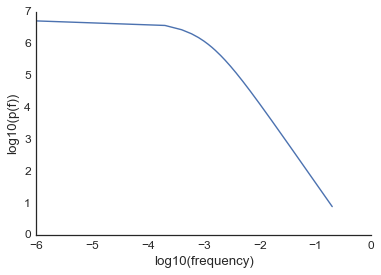

In [32]:
pi = np.pi
a = 1
R = 10
# this is what we will use to find the roots of to get the radius
# for a specific frequency value
f = np.linspace(0.000001,0.20,num=1000)

r_f = lambda r, f, R, a: f - (a**2/(4*pi))*(1/r**2 - r/R**3)
r_f_ = np.vectorize(r_f)
def pf_3d(f, R, a):
    # find the root
    r_ = optimize.root(r_f, 1, args=(f, R, a)).x[0]
    return ((8*pi**2)/a**2)*(r_**5/(1+r_**3/(2*R**3)))



pf_3d_ = np.vectorize(pf_3d)
pdf = pf_3d_(f, R, a)
not_nans = np.logical_not(np.isnan(np.log10(pdf)))
plt.plot(np.log10(f)[not_nans], np.log10(pdf)[not_nans])
# plt.plot(np.ones(50)*-3.75, np.linspace(0,18), '--')
plt.xlabel('log10(frequency)')
plt.ylabel('log10(p(f))')
# plt.ylim([0,8])
sns.despine()


No Turnover:
FREQ_SUM:6961.9
DRV_SUM:10.7
PROP DRV:0.00153693675577
Surface Turnover:
FREQ_SUM:6974.1
DRV_SUM:8.5
PROP DRV:0.00121879525674
Turnover:
FREQ_SUM:7294.4
DRV_SUM:11.1
PROP DRV:0.00152171528844
No Turnover:
FREQ_SUM:6961.9
DRV_SUM:10.7
PROP DRV:0.00153693675577
Surface Turnover:
FREQ_SUM:12683.5
DRV_SUM:50.3
PROP DRV:0.00396578231561
Could not find file:/Volumes/Stockage/u0.03simulations/1_0_065_outs_101 list index out of range
Could not find file:/Volumes/Stockage/u0.03simulations/1_0_065_outs_2 list index out of range
Turnover:
FREQ_SUM:40919.38
DRV_SUM:2591.5
PROP DRV:0.063331849114


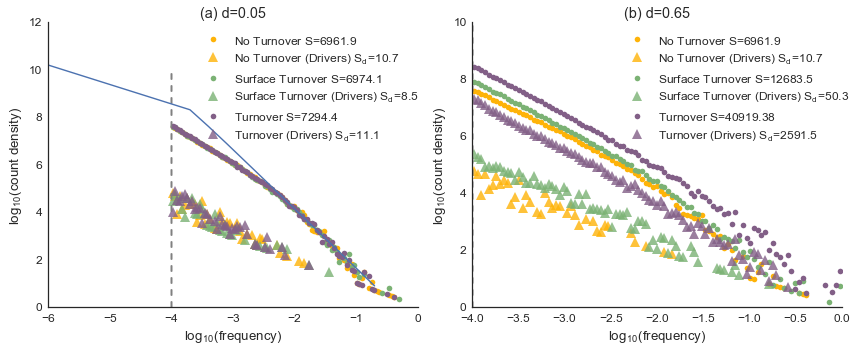

In [31]:

death_rate = '005'
root_folder = '/Volumes/Stockage/u0.03simulations/'
mappings = [ root_folder+'1_0_0_*',
            root_folder+'1_1_'+death_rate+'_*',
           root_folder+'1_0_'+death_rate+'_*']


# f = plt.figure(figsize=(6,9))
f = plt.figure(figsize=(12,5))

ax = f.add_subplot(121)

freq_plot(ax, mappings)
# plt.title('Frequency Spectra',fontsize=12)
ax.set_xlabel('$log_{10}(frequency)$')
ax.set_ylabel('$log_{10}($count density)')
ax.set_xlim([-4.15, 0.])
ax.legend(fontsize=12,loc=(0.4,0.56))
sns.despine()
ax.set_title('(a) d=0.'+death_rate[1:])
# ax.savefig('./freqspec'+death_rate+'.pdf')

death_rate = '065'
root_folder = '/Volumes/Stockage/u0.03simulations/'
mappings = [ root_folder+'1_0_0_*',
            root_folder+'1_1_'+death_rate+'_*',
           root_folder+'1_0_'+death_rate+'_*']


f1 = np.linspace(0.000001,0.20,num=1000)

pf_3d_ = np.vectorize(pf_3d)
pdf = pf_3d_(f1, R, a)
not_nans = np.logical_not(np.isnan(np.log10(pdf)))
ax.plot(np.log10(f1)[not_nans], np.log10(pdf)[not_nans])
# plt.plot(np.ones(50)*-3.75, np.linspace(0,18), '--')
# plt.ylim([0,8])
ax.set_xlim([-6, 0])



ax = f.add_subplot(122)
freq_plot(ax, mappings)
ax.set_xlabel('$log_{10}(frequency)$')
ax.set_ylabel('$log_{10}($count density)')
# ax.set_xlim([-4.15, 0])
ax.legend(fontsize=12,loc=(0.4,0.56))
sns.despine()
ax.set_title('(b) d=0.'+death_rate[1:])
plt.tight_layout(h_pad=1)
plt.savefig('./freqspec003.pdf')

No Turnover:
FREQ_SUM:6961.9
DRV_SUM:10.7
PROP DRV:0.00153693675577
Surface Turnover:
FREQ_SUM:7059.4
DRV_SUM:11.0
PROP DRV:0.00155820607984
Turnover:
FREQ_SUM:7631.5
DRV_SUM:11.1
PROP DRV:0.00145449780515
No Turnover:
FREQ_SUM:6961.9
DRV_SUM:10.7
PROP DRV:0.00153693675577
Surface Turnover:
FREQ_SUM:7242.6
DRV_SUM:9.1
PROP DRV:0.00125645486428
Turnover:
FREQ_SUM:8281.5
DRV_SUM:12.9
PROP DRV:0.00155768882449


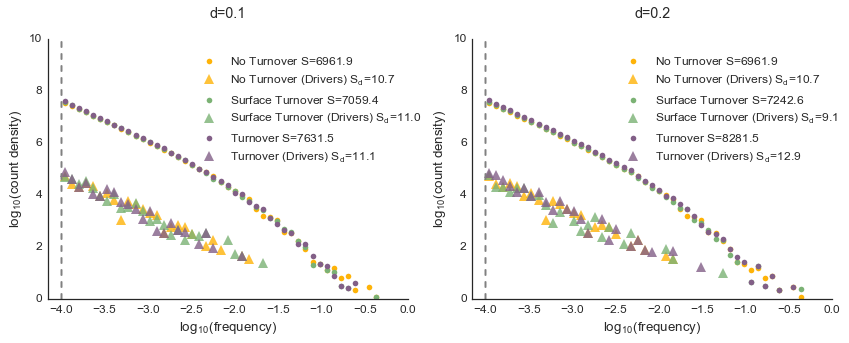

In [84]:

death_rate = '01'
root_folder = '/Volumes/Stockage/u0.03simulations/'
mappings = [ root_folder+'1_0_0_*',
            root_folder+'1_1_'+death_rate+'_*',
           root_folder+'1_0_'+death_rate+'_*']


f = plt.figure(figsize=(12,5))
ax = f.add_subplot(121)

freq_plot(ax, mappings)
# plt.title('Frequency Spectra',fontsize=12)
ax.set_xlabel('$log_{10}(frequency)$')
ax.set_ylabel('$log_{10}($count density)')
ax.set_xlim([-4.15, 0.0])
ax.legend(fontsize=12,loc=(0.4,0.5))
sns.despine()
ax.set_title('d=0.'+death_rate[1:]+'\n')
# ax.set_title('d=0')
# ax.savefig('./freqspec'+death_rate+'.pdf')

death_rate = '02'
root_folder = '/Volumes/Stockage/u0.03simulations/'
mappings = [ root_folder+'1_0_0_*',
            root_folder+'1_1_'+death_rate+'_*',
           root_folder+'1_0_'+death_rate+'_*']

ax = f.add_subplot(122)
freq_plot(ax, mappings)
ax.set_xlabel('$log_{10}(frequency)$')
ax.set_ylabel('$log_{10}($count density)')
ax.set_xlim([-4.15, 0])
ax.legend(fontsize=12,loc=(0.4,0.5))
sns.despine()
ax.set_title('d=0.'+death_rate[1:]+'\n')
plt.tight_layout(h_pad=1)
# plt.suptitle('Allele')
plt.savefig('./AFS-d003.pdf')

In [63]:
np.around(146546505,decimals=-2)

146546500